## Pruebas para un script de entrenamiento masivo

Ir probando a mano no ha funcionado, porque hay demasiadas variables, y a veces parece funcionar, pero otras no y no se donde puede estar la inconsistencia.  

El objetivo final es:  
- Lograr que sigma tome valores bajos en regiones donde hay anomalías contextuales. Esto lo he consiguido para casos de anomalías globales, pero no para las anomalías planas esas.
- Encontrar unos valores de lambda que ajusten correctamente los ratios de aprendizaje.   
- Comprobar que función pérdida va mejor, si usando LITERALMENTE lo del paper. O usando lo que da resultado como las graficas del paper (media) .


¿Para esto que queremos poder escoger facilmente con un diccionario?  
- La transformación sobre Sigma  
- lr 
- lambda
- epocas 
- ¿Pesos sobre min y max?
- ¿alguna estrategia sobre min y max?

Y para obtener los resultados que evaluaremos, tenemos que guardar:    
- Losses plot
- Ejemplo de prior, series, sigma y assdis sobre zonas anomalas.
- El criterio de decisión de anomalías.
- Txt con los hiperparámetros concretos. 
- ¿Algun plot que explore los gradientes o la variacion de parametros durante el entrenamiento? Como los sigmas. 

In [1]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

In [2]:
#dataset, nueva implementacion mas completa
class Data_anomSine(Dataset):
    def __init__(self, length=100, amp=1, sf=0.1, f=2, phase=0, anoms=1, magnitud=None, window_size=100,stride=1,anoms_c=3,f_envelope=0,range_lenght=(10,35),noise_amp=0, context_anom=True,global_anom=True,normalized=True):
        super().__init__()
        self.list_anomalies=[]
        self.anoms=anoms
        self.range_lenght=range_lenght
        self.anoms_c=anoms_c
        self.magnitud=magnitud
        self.window_size=window_size
        self.length=length
        
        if normalized:
            self.sine_wave = Data_anomSine.sinne_standardized(length, amp, sf, f, phase,noise_amp)
        else:
            self.sine_wave = Data_anomSine.sinne(length, amp, sf, f, phase,noise_amp,f_envelope)

        if context_anom:
            self.add_context_anom()
        if global_anom:
            self.add_global_anom()
        self.array = Data_anomSine.windowed_view(self.sine_wave, window_size,stride=stride)
        self.array = torch.from_numpy(self.array).unsqueeze(-1)#torch.stack([torch.from_numpy(self.array),torch.from_numpy(self.array)],-1)
        #le añadimos una dimension porque solo tiene 1 variable .unsqueeze(-1)

    def __len__(self):
        return self.array.shape[0]

    def __getitem__(self, index):
        return self.array[index]

    @staticmethod
    def sinne(length=100, amp=10, sf=0.1, f=2, phase=0,noise_amp=0,f_envelope=0):
        x = torch.arange(0, length * sf, sf)
        y =  amp *torch.cos(x * 2 * torch.pi * (f_envelope) )* torch.sin(x * 2 * torch.pi * f + phase) + (noise_amp)*torch.randn(length) 
        return y

    @staticmethod
    def standardize_signal(signal):
        mean = torch.mean(signal)
        std = torch.std(signal)
        return (signal - mean) / std

    @staticmethod
    def sinne_standardized(length=100, amp=10, sf=0.1, f=2, phase=0,noise_amp=0):
        signal = Data_anomSine.sinne(length, amp, sf, f, phase,noise_amp)
        return Data_anomSine.standardize_signal(signal)
    
    def add_global_anom(self):
        if self.magnitud is None:
            self.magnitud = self.sine_wave.max().item() - self.sine_wave.min().item()
        index = torch.from_numpy(np.random.choice(np.arange(0, self.sine_wave.size()[0]), size=self.anoms, replace=False))
        self.sine_wave[index] = torch.from_numpy(self.magnitud * np.random.randn(self.anoms)).float() + self.sine_wave[index]
        self.list_anomalies.extend([[i] for i in index.cpu().detach().numpy()])
        

    def add_context_anom(self):
        for i in range(self.anoms_c):
            points_involved = np.random.randint(*self.range_lenght)
            init_index = np.random.randint(0, self.sine_wave.size()[0] - points_involved)
            index = torch.from_numpy(np.arange(init_index, init_index + points_involved))
            self.sine_wave[index] = self.sine_wave[init_index].repeat(points_involved)
            self.list_anomalies.append(list(index.cpu().detach().numpy()))

    @staticmethod
    def windowed_view(x, window_size,stride=1):
        return np.lib.stride_tricks.sliding_window_view(x, (window_size))[::stride].copy()

# Crear una instancia de la clase con los parámetros deseados



In [3]:


class AnomalyModel:
    def __init__(self, AnomalyTransformer, dataset, batch_size=16,window_size=100,enc_in=1,enc_out=1, d_model=64, n_heads=2, e_layers=2, d_ff=32,
                 dropout=0.1, activation='relu',  lambda_=1e-3,max_norm=0.1,norm_type=2):
        self.model = AnomalyTransformer(window_size, enc_in, enc_out, d_model, n_heads, e_layers, d_ff, dropout, activation, output_attention=True)
        self.model.cuda()
        self.N=e_layers
        self.model = self.xavier_initialization(self.model)
        self.dataset=dataset
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.lambda_ = lambda_
        self.max_norm=max_norm
        self.norm_type=norm_type
        self.window_size=window_size

    @staticmethod
    def xavier_initialization(model):
        for module in model.modules():
            if hasattr(module, 'weight') and module.weight is not None and module.weight.dim() >= 2:
                nn.init.xavier_uniform_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        return model

    @staticmethod
    def my_kl_loss(p, q):
        res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
        return torch.mean(torch.sum(res, dim=-1), dim=1)

    @staticmethod
    def layer_association_discrepancy(Pl, Sl):
        B, Head, Height, _ = Pl.shape
        kl1 = AnomalyModel.my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
        kl2 = AnomalyModel.my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))
        ad_vector = kl1 + kl2
        return ad_vector

    @staticmethod
    def association_discrepancy(P_list, S_list):
        return torch.stack([AnomalyModel.layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

    @staticmethod
    def loss_function(x_hat, P_list, S_list, lambda_, x):
        frob_norm = (torch.linalg.norm(x_hat- x,dim=(1,2))**2).mean(axis=0) #((x_hat - x)**2).sum()
        #diss_norm = torch.mean(AnomalyModel.association_discrepancy(P_list, S_list))
        diss_norm = (torch.abs(AnomalyModel.association_discrepancy(P_list, S_list)).sum(dim=1)).mean()
        print(frob_norm, diss_norm)
        return (frob_norm.item(), diss_norm.item()), frob_norm - (lambda_ * diss_norm)

    @staticmethod
    def min_loss(output, P_layers, S_layers, x, lambda_):
        P_list = P_layers
        S_list = [S.detach() for S in S_layers]
        lambda_ = -lambda_
        _, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return loss_value

    @staticmethod
    def max_loss(output, P_layers, S_layers, x, lambda_):
        P_list = [P.detach() for P in P_layers]
        S_list = S_layers
        lambda_ = lambda_
        details, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return details, loss_value
    
    def cosine_lr_schedule_with_warmup(self, optimizer, epoch, initial_lr, total_epochs, warmup_epochs):
        if warmup_epochs!=0:
            if epoch < warmup_epochs:
                lr = initial_lr * (epoch + 1) / warmup_epochs
            else:
                adjusted_epoch = epoch - warmup_epochs
                adjusted_total_epochs = total_epochs - warmup_epochs
                lr = 0.5 * initial_lr * (1 + math.cos(math.pi * adjusted_epoch / adjusted_total_epochs))

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr


    def clip_gradients(self):
        """
        Clip gradients of the model parameters.

        Args:
            model (torch.nn.Module): The neural network model.
            max_norm (float): The maximum allowed norm for the gradients.
            norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
        """
        # Recupera todos los gradientes de los parámetros del modelo
        gradients = [param.grad for param in self.model.parameters() if param.grad is not None]

        # Calcula la norma total de los gradientes
        total_norm = torch.norm(torch.stack([torch.norm(grad, self.norm_type) for grad in gradients]), self.norm_type)

        # Calcula el factor de escalado para recortar los gradientes
        clip_coef = self.max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            # Aplica el factor de escalado a los gradientes
            for grad in gradients:
                grad.mul_(clip_coef)



    def schedule_lambda(self,epoch,num_epochs,init_lambda,final_lambda):
        self.lambda_=(final_lambda-init_lambda)/num_epochs * epoch + init_lambda
        
    def train(self, num_epochs, initial_lr, warmup_epochs,init_lambda,final_lambda):
        optimizer = optim.Adam(self.model.parameters(), lr=initial_lr)

        self.model.train()
        loss_frob_diss = []

        for epoch in range(num_epochs):
            print(f"Epoch: {epoch}")
            self.schedule_lambda(epoch,num_epochs,init_lambda,final_lambda)
            for i, (inputs) in enumerate(self.dataloader):
                inputs = inputs.float().to("cuda:0")
                outputs, series, prior, _ = self.model(inputs)
                #esto ya lo hacemos dentro del calculo de la perdida
                #prior = [j / torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100) for j in prior]



                loss_min = self.min_loss(outputs, prior, series, inputs, self.lambda_)
                loss_min.backward(retain_graph=True)
                #optimizer.step()
                #optimizer.zero_grad()

                details, loss_max = self.max_loss(outputs, prior, series, inputs, self.lambda_)
                loss_max.backward()
                optimizer.step()
                optimizer.zero_grad()

                loss_frob_diss.append(list(details))

                #loss_max.backward(retain_graph=True)
                #loss_min.backward()
                if self.max_norm is not None:
                    self.clip_gradients()
                #optimizer.step()
                #optimizer.zero_grad()

                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(self.dataloader)}], Loss: {loss_max.item():.4f}")
            if warmup_epochs is not None:
                self.cosine_lr_schedule_with_warmup(optimizer, epoch, initial_lr, num_epochs, warmup_epochs)

        print("Entrenamiento finalizado")
        return np.array(loss_frob_diss)
    
    def predict(self, data=None):
        if data is None:
            data = next(iter(self.dataloader)).float().to("cuda:0")
        else:
            data = torch.tensor(data).float()
            data = data.to("cuda:0") # .unsqueeze(0) -> esto si solo tiene un canal y no lo hemos puesto

        self.model.eval()
        with torch.no_grad():
            out, series, prior, sigmas = self.model(data)

        out = out.cpu().numpy()
        series = [s.cpu().numpy() for s in series]
        prior = [p.cpu().numpy() for p in prior]
        sigmas = [sigma.cpu().numpy() for sigma in sigmas]

        return data.cpu().detach().numpy(),out, series, prior, sigmas


    @staticmethod
    def anomaly_score(model, input=None, crit_batch_size=32):
        input = input.float().to("cuda:0")
        model.eval()
        num_batches = int(input.size(0) / crit_batch_size) + (1 if input.size(0) % crit_batch_size != 0 else 0)

        # Inicializa un tensÇor vacío para almacenar los resultados
        result = torch.empty(0, device="cuda:0")

        for i in range(num_batches):
            batch_start = i * crit_batch_size
            batch_end = min((i + 1) * crit_batch_size, input.size(0))

            # Procesa el lote actual
            input_batch = input[batch_start:batch_end]
            out, series, prior, sigmas = model(input_batch)
            ad = F.softmax(
                -AnomalyModel.association_discrepancy(prior, series), dim=0
            )

            norm = ((out - input_batch) ** 2).sum(axis=-1)

            score = torch.mul(ad, norm)

            # Añade el resultado del lote actual al tensor de resultado
            result = torch.cat((result, score), dim=0)

        return result





In [4]:
#tenemos el modelo entrenado en una clase, y otra case el con tipo de datos.
#ahora necesitamos algo que nos encapsule la evaluacion de los resultados obtenidos
#para ello creamos la clase
class EvalModel(object):
    def __init__(self,model_instance,dataset_instance,save_directory=None,batch_predict=16):
        self.model_instance=model_instance
        self.dataset=dataset_instance
        self.batch_predict=batch_predict
        self.window_anomalies()
        self.windowed_data2eval=self.windowed_data2eval.unsqueeze(-1) #leañadimos una dimeninsion porque oslo tiene 1 variable 
        self.run_model()


    def run_model(self):
        input = self.windowed_data2eval.float().to("cuda:0")
        self.model_instance.model.eval()
        num_batches = int(input.size(0) / self.batch_predict) + (1 if input.size(0) % self.batch_predict != 0 else 0)

        # Inicializa tensores vacíos para almacenar los resultados
        out_list =[]
        series_list =[]
        prior_list =[]
        sigmas_list =[]

        for i in range(num_batches):
            batch_start = i * self.batch_predict
            batch_end = min((i + 1) * self.batch_predict, input.size(0))

            # Procesa el lote actual
            input_batch = input[batch_start:batch_end]
            out, series, prior, sigmas = self.model_instance.model(input_batch)
            [print(k.shape) for k in series]
            # Añade el resultado del lote actual a los tensores de resultado
            out_list.append( out)
            series_list.append( torch.stack(series).transpose(0,1))#esto que nos devuelve con listas, asi que los haremos tensores
            prior_list.append( torch.stack(prior).transpose(0,1))
            sigmas_list.append( torch.stack(sigmas).transpose(0,1))

        # Guarda los resultados en los atributos de la clase
        self.out_list = torch.cat(out_list,dim=0)
        self.series_list = torch.cat(series_list,dim=0)
        self.prior_list = torch.cat(prior_list,dim=0) #el output son bloques x muestras x cabezas x Len x Len 
        self.sigmas_list = torch.cat(sigmas_list,dim=0)

    def window_anomalies(self):
        #pero en lugar de darle un batch del dataLoader, vamos a darle las ventanas en las que encontramos anomalias
        aux=[]
        for i in self.dataset.list_anomalies:
            if (i[0]-self.dataset.window_size//2)>0:
                init_window=i[0]-self.dataset.window_size//2
            else:
                init_window=0

            if (init_window+self.dataset.window_size)>self.dataset.sine_wave.shape[0]:
                end_window=self.dataset.sine_wave.shape[0]
                init_window=self.dataset.sine_wave.shape[0]-self.dataset.window_size
            else:
                end_window=init_window+self.dataset.window_size
            if (end_window-init_window)==self.dataset.window_size:
                aux.append(self.dataset.sine_wave[init_window:end_window])
        self.windowed_data2eval=torch.stack(aux)

    def evaluate_model(self):
        #aqui generamos todos los plot y todo, y los guardamos en el directorio indicado -> save_directory

        self.anomaly_score=AnomalyModel.anomaly_score(self.model_instance.model, self.windowed_data2eval)
        aux=AnomalyModel.anomaly_score(self.model_instance.model, self.dataset.array)
        empt=torch.empty(aux.shape[0],self.dataset.sine_wave.shape[0])
        empt[:]=float("nan")
        for i,j in enumerate(aux):
            empt[i,i:(i+100)]=j
        self.full_anomaly_score=np.nanmean(empt.cpu().detach().numpy(),axis=0)


    def generate_log_y_plots(self):
        #esto es la ultima funcion encargada de todo el trabajo de guarda registros y tal
        pass

In [5]:
# #tenemos el modelo entrenado en una clase, y otra case el con tipo de datos.
# #ahora necesitamos algo que nos encapsule la evaluacion de los resultados obtenidos
# #para ello creamos la clase
# class EvalModel(object):
#     def __init__(self,model_instance,dataset_object,dataset_params,save_directory):
#         self.model=model_instance
#         self.dataset=dataset_object
#         self.dataset_params=dataset_params

#     def evaluate_model(self):
#         #aqui generamos todos los plot y todo, y los guardamos en el directorio indicado -> save_directory

#         plt.hist(sigmas[1][:,:,:,0].flatten(),bins=400)

#     def run_model(self):
#         #para evaluar el modelo primero tendremos que obtener resultados o bien del mismo conjunto de entrenamiento, o de fresh new data
#         #en este caso probamos con el mismo conjunto

In [6]:
#vamos a empezar haciendo una grid search 
hyperparam_dicct={"lambda":[0.01,0.1,1,3],"sigma_a":[],"sigma_b":[],"sigma_c":[],"stop_epocas":[10,20,50,100,200,500],"clip_sigma":[True,False]}

In [7]:

# Instanciar la clase AnomalyModel con el conjunto de datos creado
dataset = Data_anomSine(length=2030, sf=0.1, f=0.5, phase=4, anoms=14,anoms_c=4, magnitud=0.6,noise_amp=0)

model_instance = AnomalyModel(AnomalyTransformer.AnomalyTransformer, dataset,n_heads=3,d_model=64,enc_in=1,enc_out=1,max_norm=None)
#model_instance.lambda_=schedule_lambda()
# Parámetros de entrenamiento
num_epochs = 10
initial_lr = 0.001
warmup_epochs = None

# Entrenar la instancia de la clase AnomalyModel

loss_frob_diss = model_instance.train(num_epochs, initial_lr,warmup_epochs,3,4)

# Ahora puedes usar 'model_instance' para hacer predicciones utilizando el método 'predict'


Epoch: 0
tensor(123.1355, device='cuda:0', grad_fn=<MeanBackward1>) tensor(863.2926, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(123.1355, device='cuda:0', grad_fn=<MeanBackward1>) tensor(863.2926, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [1/121], Loss: -2466.7424
tensor(221.2538, device='cuda:0', grad_fn=<MeanBackward1>) tensor(855.6831, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(221.2538, device='cuda:0', grad_fn=<MeanBackward1>) tensor(855.6831, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [2/121], Loss: -2345.7954
tensor(91.8844, device='cuda:0', grad_fn=<MeanBackward1>) tensor(851.9599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(91.8844, device='cuda:0', grad_fn=<MeanBackward1>) tensor(851.9599, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/10], Step [3/121], Loss: -2463.9951
tensor(125.9238, device='cuda:0', grad_fn=<MeanBackward1>) tensor(846.5643, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(125.9238, device='cuda:0'

torch.Size([16, 3, 100, 100])
torch.Size([16, 3, 100, 100])
torch.Size([2, 3, 100, 100])
torch.Size([2, 3, 100, 100])


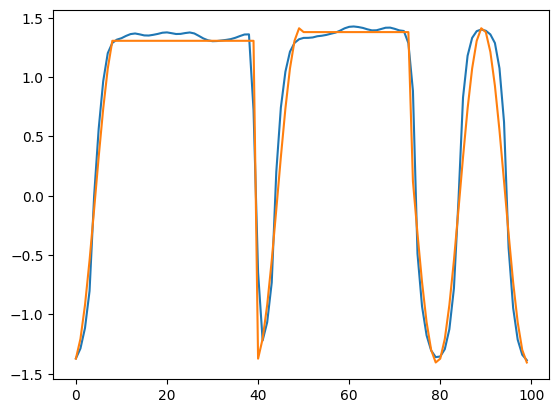

In [8]:
a=EvalModel(model_instance,dataset)
plt.plot(a.out_list[1].cpu().detach().numpy())
plt.plot(a.windowed_data2eval[1].cpu().detach().numpy())

In [9]:
a.evaluate_model()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.93 GiB total capacity; 7.01 GiB already allocated; 22.19 MiB free; 7.75 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

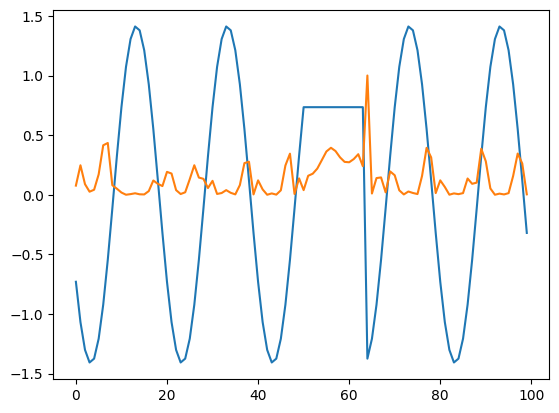

In [74]:
plt.plot(a.windowed_data2eval.cpu().detach().numpy()[0])
plt.plot(a.anomaly_score.cpu().detach().numpy()[0]/a.anomaly_score.cpu().detach().numpy()[0].max())

In [59]:
a.dataset.sine_wave.shape

torch.Size([1030])

In [60]:
a.full_anomaly_score.shape

(1030,)

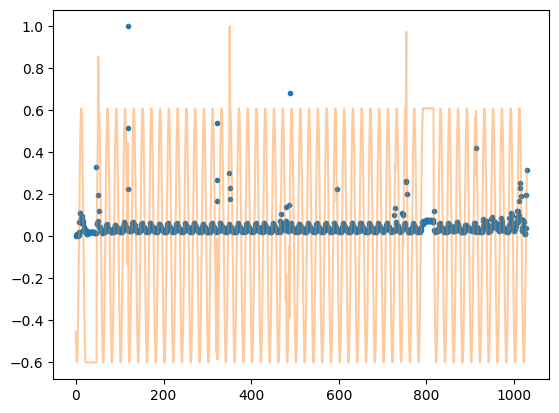

In [61]:
plt.plot(a.full_anomaly_score/a.full_anomaly_score.max(),".")
plt.plot(a.dataset.sine_wave.cpu().detach().numpy()/a.dataset.sine_wave.cpu().detach().numpy().max(),alpha=0.4)

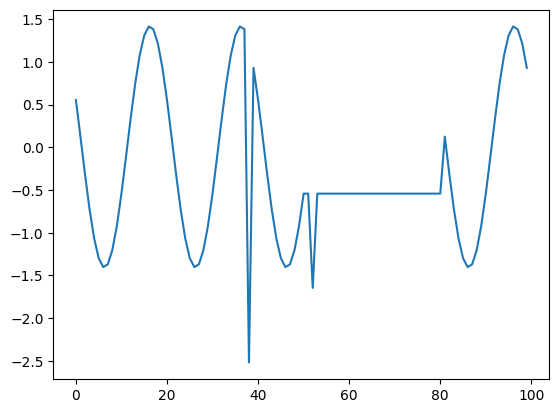

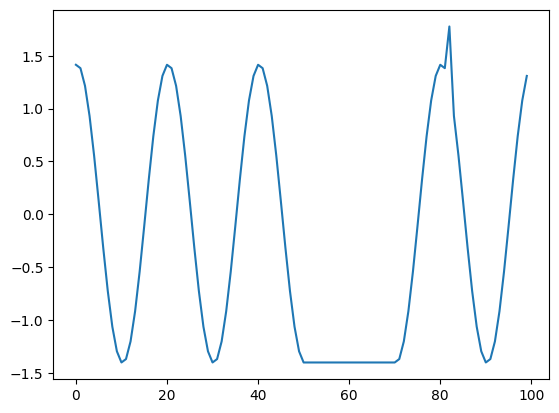

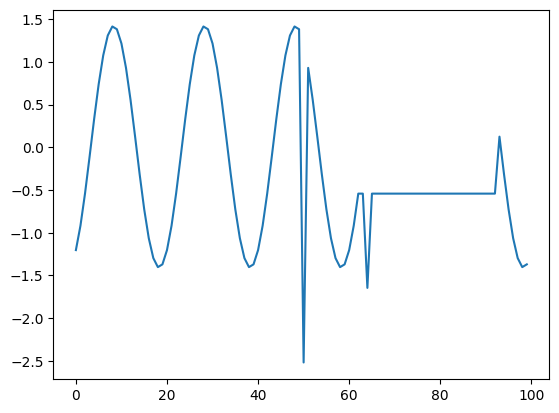

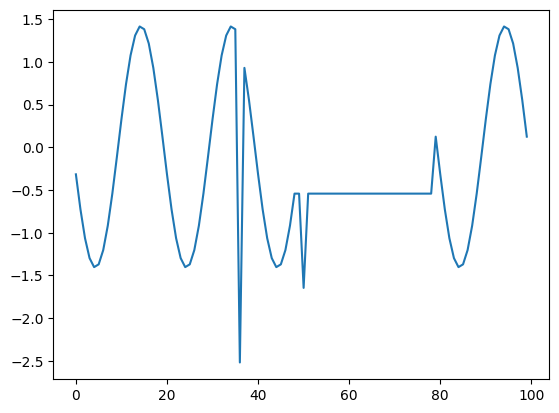

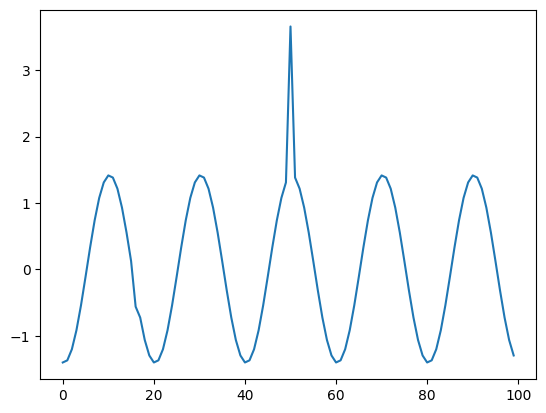

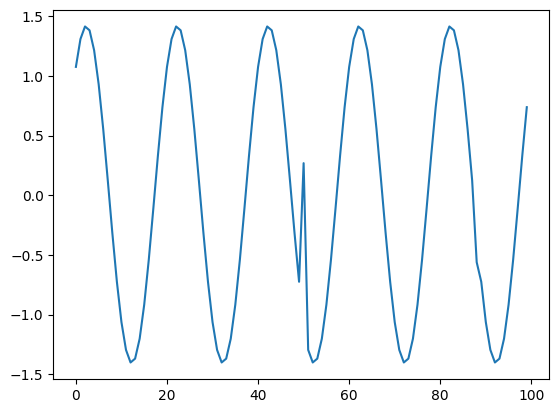

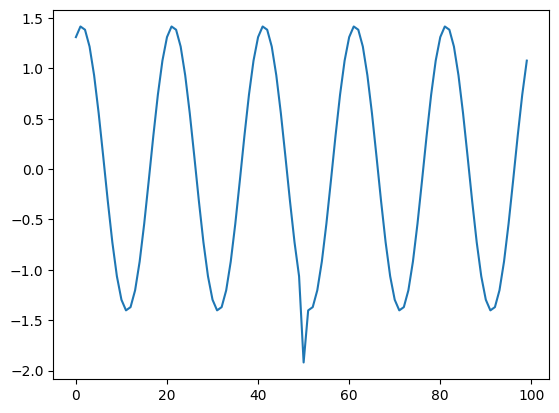

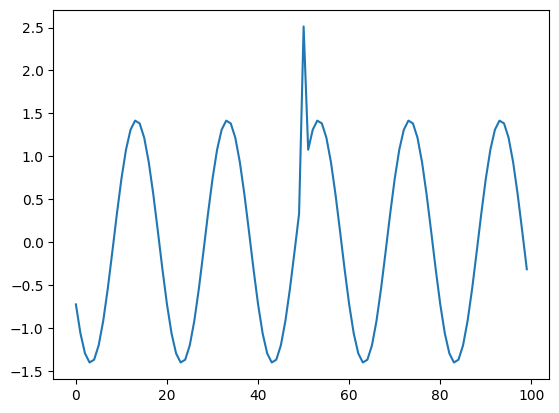

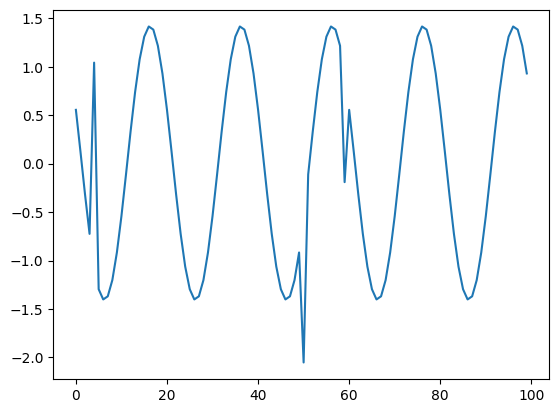

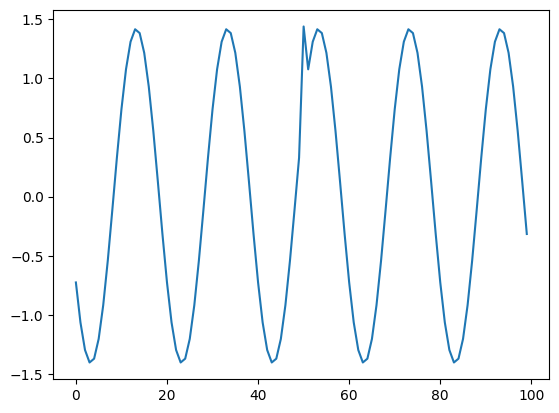

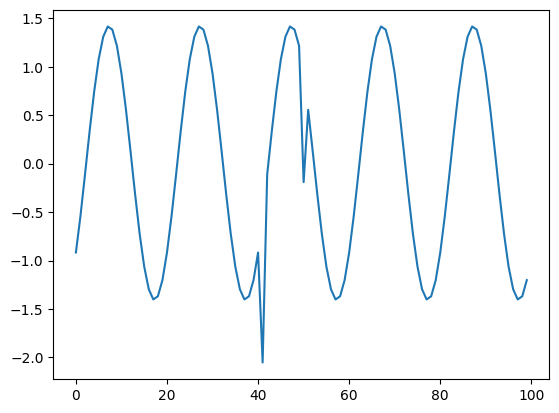

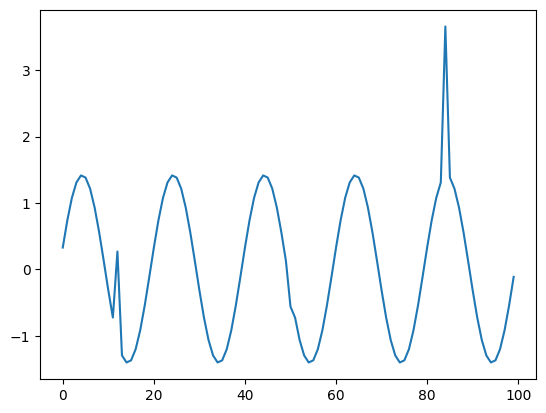

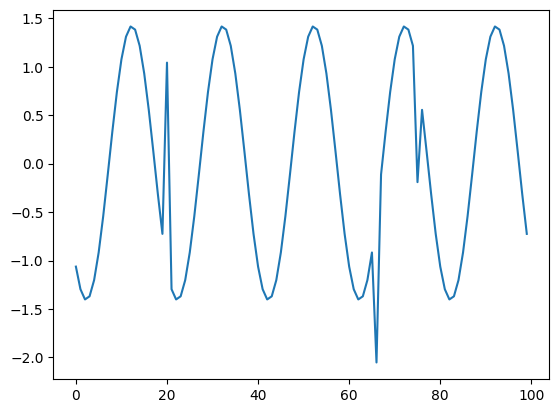

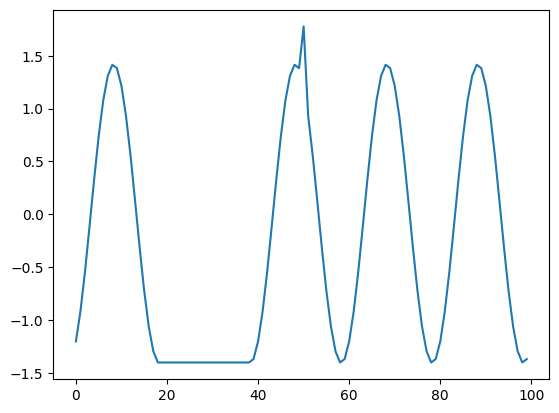

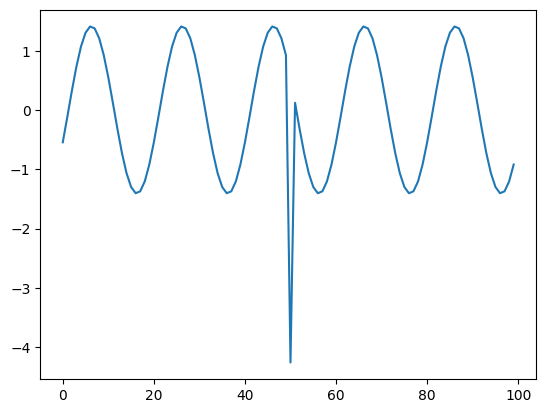

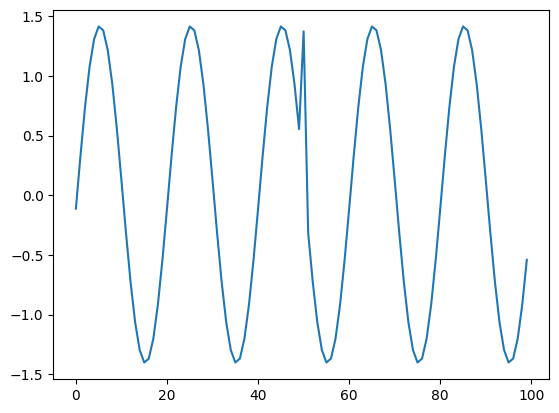

In [9]:
for i in range(a.windowed_data2eval.shape[0]):
    plt.figure()
    plt.plot(a.windowed_data2eval.cpu().detach().numpy()[i])

In [61]:
a.windowed_data2eval.shape

torch.Size([16, 100])